In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,precision_recall_curve, f1_score, accuracy_score,  precision_score, recall_score
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv("../Data/flight_dep_classi_tree.csv")

In [3]:
X = df.drop(columns=["DEP_DEL15"])
y = df["DEP_DEL15"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
lgb = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    is_unbalance=True  
)

param_grid = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [5, 7, 9, -1],
    "num_leaves": [31, 63, 127],
    "min_child_samples": [10, 20, 40],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

In [5]:
grid = GridSearchCV(
    estimator=lgb,
    param_grid=param_grid,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print(" Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
[LightGBM] [Info] Number of positive: 4242, number of negative: 31882
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1003
[LightGBM] [Info] Number of data points in the train set: 36124, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117429 -> initscore=-2.017007
[LightGBM] [Info] Start training from score -2.017007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [9]:
best_lgb = grid.best_estimator_

y_pred = best_lgb.predict(X_test)
y_prob = best_lgb.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_prob)

print("\n LightGBM Classifier – Default Threshold (0.5)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision (delay=1) : {prec:.4f}")
print(f"Recall (delay=1)    : {rec:.4f}")
print(f"F1-score (delay=1)  : {f1:.4f}")
print(f"ROC-AUC             : {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


 LightGBM Classifier – Default Threshold (0.5)
Accuracy : 0.6618
Precision (delay=1) : 0.2076
Recall (delay=1)    : 0.6679
F1-score (delay=1)  : 0.3168
ROC-AUC             : 0.7285

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9374    0.6610    0.7753      7971
         1.0     0.2076    0.6679    0.3168      1060

    accuracy                         0.6618      9031
   macro avg     0.5725    0.6645    0.5460      9031
weighted avg     0.8517    0.6618    0.7215      9031




 Threshold Optimization
Best Threshold: 0.575
Precision: 0.250
Recall:    0.543
F1-score:  0.343


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26004\899565059.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


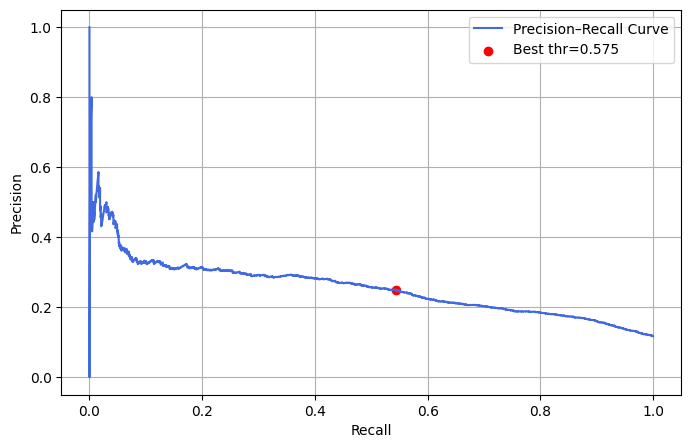

In [10]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]

print("\n Threshold Optimization")
print(f"Best Threshold: {best_threshold:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall:    {recalls[best_idx]:.3f}")
print(f"F1-score:  {f1_scores[best_idx]:.3f}")

# Precision–Recall Curve for LightGBM
plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, label="Precision–Recall Curve", color="royalblue")
plt.scatter(recalls[best_idx], precisions[best_idx], color="red", label=f"Best thr={best_threshold:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
y_pred_opt = (y_prob >= best_threshold).astype(int)

acc  = accuracy_score(y_test, y_pred_opt)
prec = precision_score(y_test, y_pred_opt)
rec  = recall_score(y_test, y_pred_opt)
f1   = f1_score(y_test, y_pred_opt)
roc  = roc_auc_score(y_test, y_prob)

print("\n LightGBM Classifier – Optimized Threshold")
print(f"Accuracy : {acc:.4f}")
print(f"Precision (delay=1) : {prec:.4f}")
print(f"Recall (delay=1)    : {rec:.4f}")
print(f"F1-score (delay=1)  : {f1:.4f}")
print(f"ROC-AUC             : {roc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt, digits=4))


 LightGBM Classifier – Optimized Threshold
Accuracy : 0.7554
Precision (delay=1) : 0.2503
Recall (delay=1)    : 0.5434
F1-score (delay=1)  : 0.3428
ROC-AUC             : 0.7285

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9281    0.7836    0.8497      7971
         1.0     0.2503    0.5434    0.3428      1060

    accuracy                         0.7554      9031
   macro avg     0.5892    0.6635    0.5962      9031
weighted avg     0.8485    0.7554    0.7902      9031



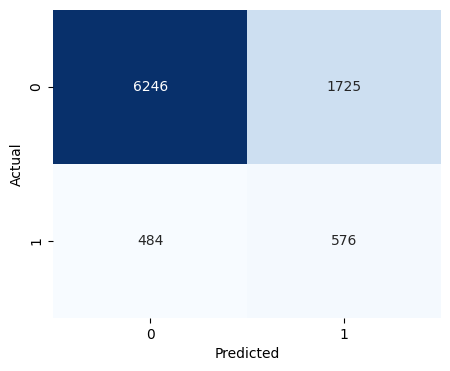

In [19]:
# Confusion matrix - Best threshold
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5,1.5], ["0", "1"])
plt.yticks([0.5,1.5], ["0", "1"])
plt.show()

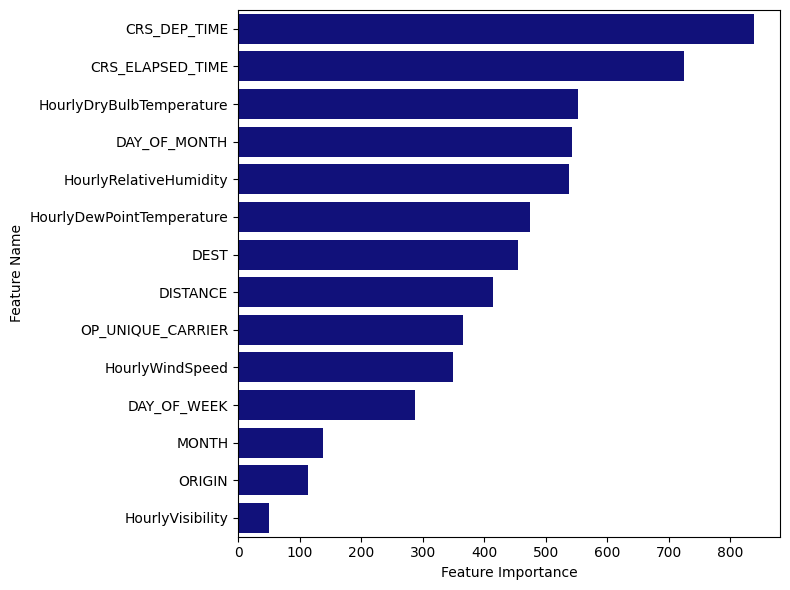

In [18]:
# Top 15 Important Features – LightGBM
importances = best_lgb.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    data=feat_imp.head(15),
    x="Importance", y="Feature",
    color="darkblue"
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()